In [2]:
#Function Definitions
#
#Adapted from Qiskit Textbook
from qiskit import *
import numpy as np
from math import *
from qiskit.visualization import plot_histogram
#

#Converts binary values to decimal
def binary_to_decimal(binary):
    return int(binary,2)

#Creates the unitaries
def ax_mod15(a, iterations):
    qc = QuantumCircuit(4)
    for iteration in range(iterations):
        if a == 2:
            qc.swap(0, 1)
            qc.swap(1, 2)
            qc.swap(2, 3)
        if a == 7:
            qc.swap(2, 3)
            qc.swap(1, 2)
            qc.swap(0, 1)
            for q in range(4):
                qc.x(q)
        if a == 8:
            qc.swap(2, 3)
            qc.swap(1, 2)
            qc.swap(0, 1)
        if a == 11:
            qc.swap(1, 3)
            qc.swap(0, 2)
            for q in range(4):
                qc.x(q)
        if a == 13:
            qc.swap(0, 1)
            qc.swap(1, 2)
            qc.swap(2, 3)
            for q in range(4):
                qc.x(q)
    qc = qc.to_gate()
    qc.name = "%i^%i mod 15" % (a, iterations)
    control_qc = qc.control()
    return control_qc

#modular exponetiation
def mod_exponentiation(qc, n, m, a):
    for x in range(n):
        qc.append(ax_mod15(a, 2**x), [x] + list(range(n, n + m))) 

#inverse qft
def qft_inverse(qubits):
    qc = QuantumCircuit(qubits)
    for i in range(qubits//2):
        qc.swap(i, qubits-i-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT^-1"
    return qc

#inverse qft 
def iqft(qc, n):
    qc.append(qft_inverse(len(n)), n)

#Creates the circuit   
def circ(n, m, a):
    #n = register 1
    #m = register 2 (control register)
    qc = QuantumCircuit(n + m, n)
    qc.h(range(n))
    qc.x(n + m - 1)    
    mod_exponentiation(qc, n, m, a)              
    iqft(qc, range(n))   
    qc.measure(range(n), range(n))            
    return qc

#Converts a dictionary to a list
def dict_to_list(dictionary):
    list_placeholder = []
    for i in dictionary.keys():
        list_placeholder.append(i)
          
    return list_placeholder
#


In [13]:
#backends for deciding whether to ue a real quantum device or a simulator
#comment out this if you would like to use a real quantum computer for the job
########Simulator##########
simulator = Aer.get_backend('qasm_simulator')
backend = simulator
#########On a real QC###########
factor1 = 0
factor2 = 0
M = 8 #length of input vector
while(factor1 == 0 & factor2 == 0):
    ############CLASSICAL_IMPLEMENTATION######################
    from math import *
    from random import randint
    N = 15
    factor1 = 0
    factor2 = 0
    #Step 1, pick a, a random number between 1 and N (exclusive)
    a = randint(2,N-1) #a is set to a random number between 2 and 20 (inclusive)
    #a=11 #for testing purposes 
    print("N is", N, "and a is", a)
    if a == 4 or a == 14:
        print("A=4 or 14 does not work for this implementation of Shor's Algorithm")
        break
    #Step 2, compute the greatest common divisor of a and N
    k = gcd(a, N)
    print("k, the greatest common divisor, is", k)
    #Step 3, could be done if k is not equal to one
    if k != 1:
        factor1 = k
        factor2 = int(N/k)
        print("The factors of", N, "are", factor1, "and", factor2)
        break
    else:
        print("Factors of", N, "are still unknown, Quantum Period Finding subroutine required to find factors")
        ###########QUANTUM_COMPUTER_IMPLEMENTATION#################
        import numpy as np
        #Step 4, run the QPF subroutine and find r, the period of a^x mod N
        n = 3
        m = 4
        circuit = circ(n, m, a)
        print(circuit.draw(fold=-1))
        counts = execute(circuit, backend=simulator).result().get_counts(circuit)
        #Next, need to find r and from the measured outputs
        dict_counts = dict(counts)
        #for i in list_of_periods:
            #print(binary_to_decimal(i))
        print(counts.int_outcomes())
        print(dict_counts, "length is ", len(dict_counts))
        if backend == simulator:
            if len(dict_counts) == 2:
                r = 2
            if len(dict_counts) == 4:
                r = 4
        else:
            int_2 = counts.get('010', default=None)
            print("int2 is", int_2)
            if int_2 >= 150:
                r = 4
            else:
                r = 2
        
        ###################Back to Classical Implementation###########################
        #Step 5, if r is odd, go back to step 1, and Step 6, if a^(r/2) = -1modN, go back to step 1
        if r == 0 or int(a)^(int(r/2)) == -1 % N or r % 2 == 1:
            print("There was an issue with the code")
            break
        #Step 7, perform gcd(a^(r/2)+-1, N)
        else:
            power = pow(a,r/2)
            power = int(power)
            #print(power)
            value1 = gcd(N, power + 1)
            value2 = gcd(N, power - 1)
            if int(value1) != 1:
                factor1 = value1
                factor2 = N / factor1
            elif int(value2) != 1:
                factor2 = value2
                factor1 = N / factor2
            print("The factors of", N, "are", int(factor1), "and", int(factor2))
            break
        break

N is 15 and a is 13
k, the greatest common divisor, is 1
Factors of 15 are still unknown, Quantum Period Finding subroutine required to find factors
     ┌───┐                                                ┌─────────┐┌─┐      
q_0: ┤ H ├───────■────────────────────────────────────────┤0        ├┤M├──────
     ├───┤       │                                        │         │└╥┘┌─┐   
q_1: ┤ H ├───────┼───────────────■────────────────────────┤1 QFT^-1 ├─╫─┤M├───
     ├───┤       │               │                        │         │ ║ └╥┘┌─┐
q_2: ┤ H ├───────┼───────────────┼───────────────■────────┤2        ├─╫──╫─┤M├
     └───┘┌──────┴───────┐┌──────┴───────┐┌──────┴───────┐└─────────┘ ║  ║ └╥┘
q_3: ─────┤0             ├┤0             ├┤0             ├────────────╫──╫──╫─
          │              ││              ││              │            ║  ║  ║ 
q_4: ─────┤1             ├┤1             ├┤1             ├────────────╫──╫──╫─
          │  13^1 mod 15 ││  13^2 mod 15 ││  13^4 mod 15 │   

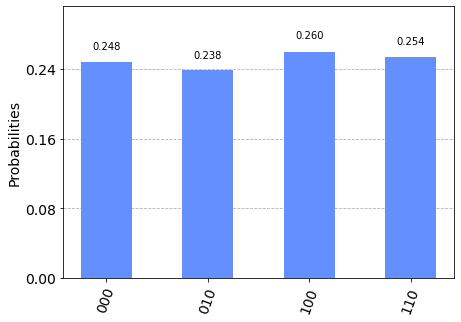

In [14]:
#Executing the job on a simulator
job = execute(circuit, backend)
plot_histogram(job.result().get_counts())

62c44a38b3f348840ef28047


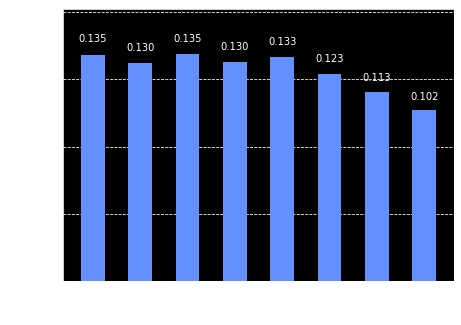

In [3]:
#Running the job on a real QC
IBMQ.load_account()
transpiled_circuit = transpile(circuit)
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
provider.backends()
backend = provider.get_backend('ibm_nairobi') #only available on select plans now
job = execute(transpiled_circuit, backend)

#displaying the data from the jobs
print(job.job_id())
job = backend.retrieve_job(job.job_id()) 
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plot_histogram(job.result().get_counts())